# Using Facial Emotions to Potentially Boost Retail Sales

This project explores the potential of using facial emotion recognition to boost sales within retail stores. Outside of online and print advertisements, retail stores have displays that draws in potential customers. This project attempts to draw in potential customers into retail stores by determining their facial emotion and using that to quickly decide on whether to change the displays available. While an facial emotion displaying one of disgust and fear may stop someone from entering the retail store, an emotion displaying happiness, or surprise may draw them in.

## Table of Contents

[Initializations](#Initializations)

[Dataset](#Dataset)

[Modeling](#Modeling)

## Initializations

In this section are a couple of variables that will be initialized and used throughout the project

In [1]:
# model related initializations
load_model = True
model_path = ''
model_name = 'facial_expression_normalization_model.h5'
batch_size = 64
epochs = 15

# dataset related initialization
# out of the 7 emotions available in the dataset, only 5 will be utilized: angry, disgust, happy, surprise, neutral
num_classes = 5
emotion_values = ['angry', 'disgust', 'happy', 'surprise', 'neutral']
width, height, color = 48, 48, 1
input_shape = (width, height, color)

# initialize training and test set
x_train, y_train, x_test, y_test = [], [], [], []

## Dataset

The dataset used to train facial emotions comes from a previous [2013 kaggle competition](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge). This dataset contains over 28,000 training data and over 7,000 test data used to validate and test the model. Each image contained within the dataset is a 48x48 pixel grayscale image of a face. The images are relatively centered and occupies about the same amount of space in each image.

In [2]:
with open("fer2013.csv") as f:
    content = f.readlines()

In [3]:
# see sample content of csv file
print(content[0])
print(content[1])

emotion,pixels,Usage

0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 2

As we observe from the output of the first two lines of the dataset file, we notice that it contains three features: emotion, pixels, and Usage. Emotion is a labeling feature that categorizes the facial expression to one of seven categories (0 = Angry, 1 = Disgust, 2 = Fear, 3 = Happy, 5 = Sad, 5 = Surprise, 6 = Neutral). For this project's intents and purposes, we will be primarily be looking at five emotions, anger, disgust, happy, surprise, and neutral. The emotions fear and sadness do not apply to this type of advertisement.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
%matplotlib inline

Using TensorFlow backend.


In [5]:
faces = np.array(content)
print("There are a total of {} pictures".format(len(faces)))

There are a total of 35888 pictures


In [6]:
for i, instance in enumerate(faces):
    
    # skip first step; header
    if i == 0:
        continue
    
    emotion, pixel, usage = instance.split(',')
    
    img = np.array(pixel.split(" "))
    
    if emotion in ['0', '1', '3', '5', '6']:
        
        if emotion == '5':
            emotion = '2'
        if emotion == '6':
            emotion = '4'
    
        if 'Training' in usage:
            x_train.append(img)
            y_train.append(emotion)
        else:
            x_test.append(img)
            y_test.append(emotion)
        
print("There are {} training data and {} test cases".format(len(y_train), len(y_test)))

There are 19782 training data and 4907 test cases


After removing two of the facial emotions, the training data drops from over 28,000 to around 19,000 and the training data drops from over 7,000 to around 4,900

## Modeling

Now that the data is loaded, it is now time to generate a model that will be able to classify the emotions. First, a baseline accuracy rate will be determined using Principal Component Analysis (PCA) and a Random Forest model. Once I find a baseline accuracy rate, I'll then use a convolutional neural network (CNN) using Keras and Tensorflow will be used to improve upon it.

## Setting the Baseline

In [7]:
import pandas as pd

feat_cols = [ 'pixel '+str(i+1) for i in range(width*height*color)]
df = pd.DataFrame(x_train+x_test, columns=feat_cols)
df['label'] = y_train+y_test

In [8]:
df.head()

,pixel 1,pixel 2,pixel 3,pixel 4,pixel 5,pixel 6,pixel 7,pixel 8,pixel 9,pixel 10,...,pixel 2296,pixel 2297,pixel 2298,pixel 2299,pixel 2300,pixel 2301,pixel 2302,pixel 2303,pixel 2304,label
0,70,80,82,72,58,58,60,63,54,58,...,182,183,136,106,116,95,106,109,82,0
1,151,150,147,155,148,133,111,140,170,174,...,108,95,108,102,67,171,193,183,184,0
2,4,0,0,0,0,0,0,0,0,0,...,34,31,31,31,27,31,30,29,30,4
3,77,78,79,79,78,75,60,55,47,48,...,124,139,150,179,180,175,125,67,68,3
4,85,84,90,121,101,102,133,153,153,169,...,151,111,106,102,99,89,58,73,84,3


In [9]:
# get position of label for use later
label_pos = len(df.columns)-1

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
df['pca-four'] = pca_result[:,3]
df['pca-five'] = pca_result[:,4]

print(pca.explained_variance_ratio_)

[0.29064697 0.10268338 0.09279428 0.05513855 0.0315017 ]


In [11]:
# show the dataframe with the pca values
df.head()

,pixel 1,pixel 2,pixel 3,pixel 4,pixel 5,pixel 6,pixel 7,pixel 8,pixel 9,pixel 10,...,pixel 2301,pixel 2302,pixel 2303,pixel 2304,label,pca-one,pca-two,pca-three,pca-four,pca-five
0,70,80,82,72,58,58,60,63,54,58,...,95,106,109,82,0,728.167470,-624.352520,675.851722,-413.355678,-511.295988
1,151,150,147,155,148,133,111,140,170,174,...,171,193,183,184,0,-44.269447,755.789107,-382.175539,-496.038392,-663.134919
2,4,0,0,0,0,0,0,0,0,0,...,31,30,29,30,4,1844.072825,-1748.535295,-911.142176,-3.464172,-363.262506
3,77,78,79,79,78,75,60,55,47,48,...,175,125,67,68,3,1065.058390,-1211.813408,166.291973,604.469999,694.978138
4,85,84,90,121,101,102,133,153,153,169,...,89,58,73,84,3,-1564.419220,-2234.973442,425.538857,-156.843904,-9.176168


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier()
average_score = cross_val_score(rf, df.iloc[:, label_pos+1:], df.iloc[:, label_pos], cv=10)

In [13]:
print('Baseline performance of the Random Forest model with PCA values is {0:.2f}% with a standard deviation of +/- {1:.2f}'.format(average_score.mean()*100, average_score.std()*2))

Baseline performance of the Random Forest model with PCA values is 42.57% with a standard deviation of +/- 0.02


Now that the baseline accuracy has been achieved, the CNN model will be run with the intent of performing better than the Random Forest model accuracy rating.

In [14]:
# from keras.preprocessing.image import , img_to_array
# from keras.models import Sequential, Model
# from keras.layers import , Activation, , , 
# from keras.applications.inception_v3 import InceptionV3, preprocess_input

# from keras.optimizers import RMSprop

In [31]:
from keras.preprocessing.image import array_to_img, image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, AveragePooling2D, BatchNormalization, Flatten, Dense
from keras import backend as K

In [16]:
# allocates GPU memory based on runtime allocations. doesn't releases memory because of potential memory fragmentation
# without this option, getting images will not work
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

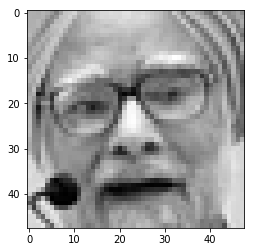

In [17]:
# sample picture
sample = np.array(faces[2].split(",")[1].split(" "))
sample = sample.reshape(width, height, 1)
plt.imshow(array_to_img(sample))

In [18]:
# convert the labels into categories
tmp = []
for emotion in y_train:
    emotion = keras.utils.to_categorical(emotion, num_classes)
    tmp.append(emotion)

y_train = tmp
    
tmp = []
for emotion in y_test:
    emotion = keras.utils.to_categorical(emotion, num_classes)
    tmp.append(emotion)

y_test = tmp

In [19]:
# need to convert list into arrays to work with CNNs
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

# normalize values between 0 - 1
x_train = x_train / 255.0
x_test = x_test / 255.0

# reshape values into image format
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, width, height)
    x_test = x_test.reshape(x_test.shape[0], 1, width, height)
    input_shape = (1, width, height)
else:
    x_train = x_train.reshape(x_train.shape[0], width, height, 1)
    x_test = x_test.reshape(x_test.shape[0], width, height, 1)
    input_shape = (width, height, 1)

In [20]:
# create CNN model
model = Sequential()

# first CNN layer
model.add(Conv2D(49, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

# second CNN layer
model.add(Conv2D(49, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))

# third CNN layer
model.add(Conv2D(98, (3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(784, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [21]:
if (load_model):
    model.load(weights(model_path+model_name))
else:
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    model.save_weights(model_path+model_name)

Train on 19782 samples, validate on 4907 samples
Epoch 1/15
19782/19782 [==============================] - 10s 525us/step - loss: 1.2566 - acc: 0.4676 - val_loss: 1.0047 - val_acc: 0.6069
Epoch 2/15
19782/19782 [==============================] - 8s 421us/step - loss: 0.9959 - acc: 0.6058 - val_loss: 0.9486 - val_acc: 0.6146
Epoch 3/15
19782/19782 [==============================] - 8s 398us/step - loss: 0.8995 - acc: 0.6445 - val_loss: 0.7891 - val_acc: 0.6892
Epoch 4/15
19782/19782 [==============================] - 8s 381us/step - loss: 0.8379 - acc: 0.6719 - val_loss: 0.8155 - val_acc: 0.6670
Epoch 5/15
19782/19782 [==============================] - 8s 380us/step - loss: 0.8021 - acc: 0.6900 - val_loss: 0.7120 - val_acc: 0.7216
Epoch 6/15
19782/19782 [==============================] - 8s 381us/step - loss: 0.7639 - acc: 0.7036 - val_loss: 0.6949 - val_acc: 0.7292
Epoch 7/15
19782/19782 [==============================] - 7s 376us/step - loss: 0.7379 - acc: 0.7170 - val_loss: 0.6987 - 

While the CNN model does appear to perform better than the Random Forest model, let's see if it's possible to improve it even more.

In [22]:
# create CNN model
model = Sequential()

# first CNN layer
model.add(Conv2D(64, kernel_size=(4, 4),
                 activation='relu',
                 input_shape=input_shape))

# second CNN layer
model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.2))

# third CNN layer
model.add(Conv2D(128, (4,4), activation='relu'))
model.add(AveragePooling2D(pool_size=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))

model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# model.save_weights(model_path+model_name)

Train on 19782 samples, validate on 4907 samples
Epoch 1/15
19782/19782 [==============================] - 11s 552us/step - loss: 1.3881 - acc: 0.3811 - val_loss: 1.3547 - val_acc: 0.4072
Epoch 2/15
19782/19782 [==============================] - 10s 484us/step - loss: 1.2622 - acc: 0.4582 - val_loss: 1.2843 - val_acc: 0.4626
Epoch 3/15
19782/19782 [==============================] - 10s 491us/step - loss: 1.2010 - acc: 0.4929 - val_loss: 1.1297 - val_acc: 0.5425
Epoch 4/15
19782/19782 [==============================] - 11s 538us/step - loss: 1.1576 - acc: 0.5276 - val_loss: 1.1317 - val_acc: 0.5213
Epoch 5/15
19782/19782 [==============================] - 10s 492us/step - loss: 1.1053 - acc: 0.5532 - val_loss: 1.0683 - val_acc: 0.5861
Epoch 6/15
19782/19782 [==============================] - 10s 498us/step - loss: 1.0720 - acc: 0.5723 - val_loss: 1.0135 - val_acc: 0.6012
Epoch 7/15
19782/19782 [==============================] - 10s 485us/step - loss: 1.0406 - acc: 0.5899 - val_loss: 0.9

## Identifying Issues with Emotions
Now that the accuracy of the CNN model has been improved, let's observe which facial emotion the model has the most trouble identifying and see if it can be improved

In [23]:
def emotion_breakdown(emotions):
    emotion = ('angry', 'disgust', 'happy', 'surprise', 'neutral')
    y_pos = np.arange(len(emotion))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, emotion)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

In [24]:
def return_confidence(values, diff=.25):
    sorted_values = np.sort(values)

    if sorted_values[-1] - diff > sorted_values[2]:
        return True
    return False

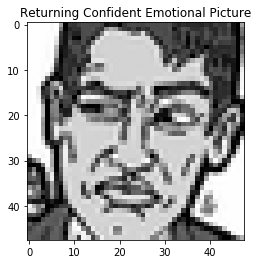

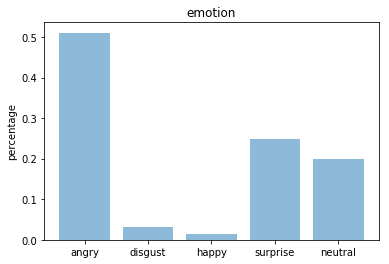

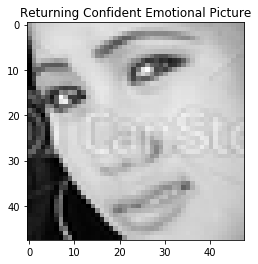

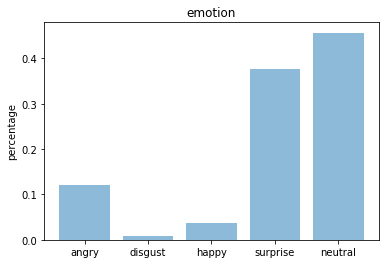

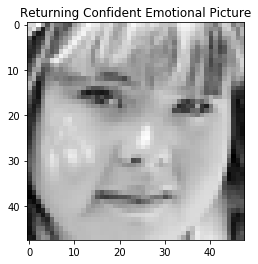

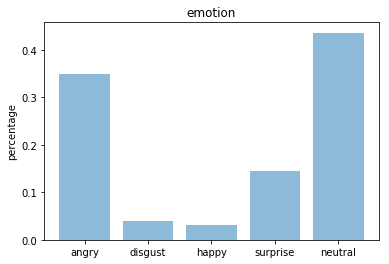

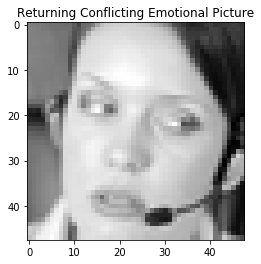

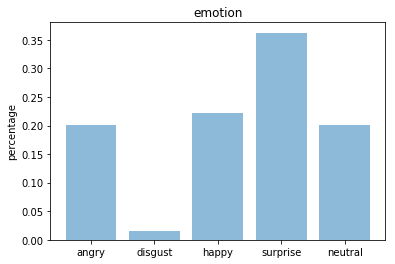

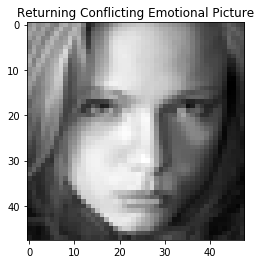

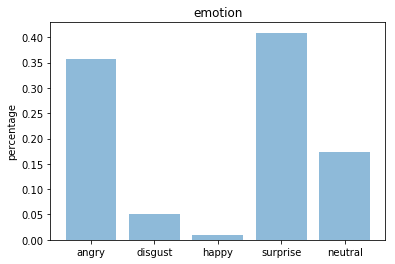

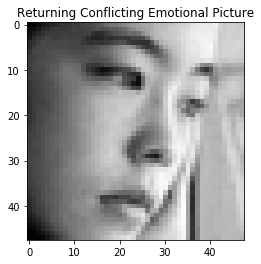

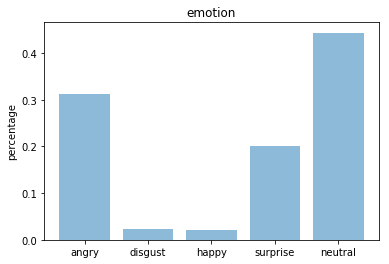

In [25]:
predictions = model.predict(x_test)

num_confident, num_unsure = 0, 0
max_confident, max_unsure = 3, 3
plt.gray()

for i, prediction_image in enumerate(predictions):
    
    # only print out up to a certain amount of confident and unsure graphs
    if ((num_confident == max_confident) and (num_unsure == max_unsure)):
        break
    
    val = return_confidence(prediction_image)
    
    if (val and num_confident < max_confident):
        testing_img = np.array(x_test[i], 'float32')
        testing_img = testing_img.reshape(width, height)

        plt.title('Returning Confident Emotional Picture')
        plt.imshow(testing_img)
        plt.show()
        emotion_breakdown(prediction_image)
        
        num_confident += 1
    elif(not val and num_unsure < max_unsure):
        testing_img = np.array(x_test[i], 'float32')
        testing_img = testing_img.reshape(width, height)

        plt.title('Returning Conflicting Emotional Picture')
        plt.imshow(testing_img)
        plt.show()
        emotion_breakdown(prediction_image)
        
        num_unsure += 1

In [27]:
# set up dictionary to generate crosstab
dic = {key:value for key, value in zip(list(set(y_test.argmax(axis=-1))), emotion_values)}

# convert id values into string values
prediction_string = []
actual_string = []

for value in predictions.argmax(axis=-1):
    prediction_string.append(dic[value])

for value in y_test.argmax(axis=-1):
    actual_string.append(dic[value])

In [28]:
# create categorical variables to input into crosstab
prediction = pd.Categorical(prediction_string, categories=emotion_values)
actual = pd.Categorical(actual_string, categories=emotion_values)

num_cross = pd.crosstab(prediction, actual, rownames=['Prediction'], colnames=['Actual'])
num_cross

Actual,angry,disgust,happy,surprise,neutral
Prediction,,,,,
angry,457,54,35,64,117
disgust,1,9,0,0,0
happy,25,3,504,36,21
surprise,281,30,143,1530,328
neutral,194,15,149,144,767


In [32]:
# test
test_image = image.load_img('D:/Pictures/2016 San Francisco/IMG_20161204_094714760.jpg',  color_mode='grayscale', target_size=(width, height))

x = image.img_to_array(test_image) / 255.0


if K.image_data_format() == 'channels_first':
    x = x.reshape(1, 1, width, height)
    input_shape = (1, width, height)
else:
    x = x.reshape(1, width, height, 1)
    input_shape = (width, height, 1)
    
prediction = model.predict(x)

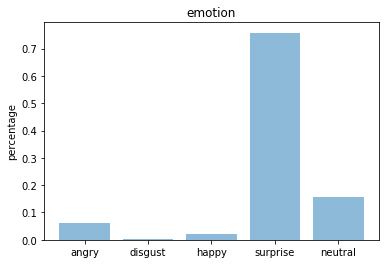

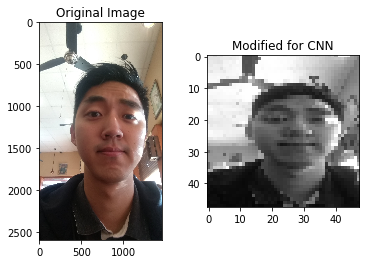

In [33]:
emotion_breakdown(prediction[0])
fig, ax = plt.subplots(1,2)

ax[0].imshow(image.load_img('D:/Pictures/2016 San Francisco/IMG_20161204_094714760.jpg'))
ax[0].set_title('Original Image')

ax[1].imshow(test_image)
ax[1].set_title('Modified for CNN')

plt.show()